## Implementing Decision Tree from scratch

The implementation of the DT does a binary split where the gini index loss is used. The implementation provides the following features:

- Allow for classification in the multiclass setting.
- The gini loss is
\begin{align}
l = \sum_{k=1}^c \hat p_{mk}(1 - \hat p_{mk})
\end{align}
where $\hat p_{mk}$ is the empirical fraction of samples in some region $m$ of the space belonging to class $k$ out of $c$ total class labels, is general to the number of classes c.

- The maximum depth of the decision tree can be controlled through a user-selected parameter
- The implementation is positioned for application as part of the Random Forest algorithm, and implements two feature subsampling methods, to randomly select from $m < p$ input features for determining the best split, for each split in the tree-building process. In other words, each split evaluate only the selected subset of features. Specifically, allow for the user to select from $m=p$ (no subsampling), $m = p/2$, and $m=\sqrt{p}$ features.
- Stopping criterion is a combination of both max depth and negligible increase in purity after best split

In [ ]:
import pandas as pd
import numpy as np

class Node:
  def __init__(self, value):
    # self.value is (variable name for split, predicted value
    # (i.e. majority class), number split at)
    # The number split at for a binary categorical variable is always 1/2

    # self.left and right are the children nodes. (split for <= is the left
    # child and split for > is the right child)
    self.value = value
    self.left = None
    self.right = None

def prediction(x, dt):
  # Make a prediction of the sample x using the trained decision tree dt

  # if one branch of the split is empty, then information gain is 0 which means
  # the stopping criteria is applied as 0 < delta for sure as delta > 0. This
  # means left child and right child are None, (i.e. this node is a leaf) so we
  # just return the prediction
  if dt.left is None:
    return dt.value[1]

  # Run prediction on the left child
  elif x[dt.value[0]] <= dt.value[2]:
    return prediction(x, dt.left)

  # Run prediction on the right child
  else:
    return prediction(x, dt.right)

def best_feature_to_split(X, y):
  # X is pandas dataframe with features as column
  # y is pandas dataframe with one column containing the labels
  # returns the best split as a tuple (total loss, feature, split number)
  labels = y.unique()
  N = len(y)
  each_feature_loss = []

  for i in range(X.shape[1]):

    # Name of the feature to split
    name = X.columns[i]

    # np array of the feature
    feature = X.iloc[:, i].to_numpy()

    # get unique values for the feature
    x = np.unique(feature)

    # get midpoints to use as the split points
    if len(x) == 1:
      midpoints = x
    else:
      midpoints = (x[1:] + x[:-1])/2

    # Calculate the impurity for every split and add to each_feature_loss list
    for split in midpoints:
      # left split
      S_1 = y[X[name] <= split]
      # right split
      S_2 = y[X[name] > split]

      # Calculate the gini index for each split

      if len(S_1) == 0:
        # empty branch split has maximum impurity just a definition I set for
        # consistency
        gini_1 = 0.25
      else:
        s1_prob = S_1.groupby(y).count().div(len(S_1)).to_numpy()
        gini_1 = np.sum(s1_prob * (1 - s1_prob))

      if len(S_2) == 0:
        # empty branch split has maximum impurity just a definition I set for
        # consistency
        gini_2 = 0.25
      else:
        s2_prob = S_2.groupby(y).count().div(len(S_2)).to_numpy()
        gini_2 = np.sum(s2_prob * (1 - s2_prob))

      total_loss = ((len(S_1)/N) * gini_1) + ((len(S_2)/N) * gini_2)

      each_feature_loss.append((total_loss, name, split))

  return each_feature_loss[np.argmin(\
   [x[0] for x in each_feature_loss])]

def LearnDecisionTree(X, y, delta, m, d):
  """ Learn a decision tree with maximum depth d and stopping criteria of
  information gain less than delta while letting the user select m, the number
  of features to be randomly sampled to decide the best split for each split.

  Args:
    X: pandas dataframe with features as column
    y: pandas dataframe with one column being the label
    delta: if information gain or increase in purity is less than delta, then
    the improvement is negligible and we do not split (i.e. a stopping criteria)
    m: number of features to subsample
    d: the maximum depth of the tree

  Returns: The root node of the decision tree
  """

  # calculate point estimate
  point_est = y.mode().iloc[0]

  # find the best split
  num_features = int(np.ceil(m))
    # randomly sample num_features features to consider for the split
  features = X.sample(n = num_features, axis = 1)
  best_feature = best_feature_to_split(features, y)

  # Calculate initial loss for calculating information gain later. Our stopping
  # criteria is when the information gain is negligible.
  proportion_of_labels = y.groupby(y).count().div(len(y)).to_numpy()
  initial_loss = np.sum(proportion_of_labels * (1 - proportion_of_labels))
  after_loss = best_feature[0]

  root = Node((best_feature[1], point_est, best_feature[2]))

  # STOPPING CRITERIA: if the information gain/increase in purity is negligible
  # (i.e. very low), we might as well not split. This is combined with the
  # stopping criteria where a split will not be made if it makes the depth of
  # the tree exceed d
  if (d == 0) or (initial_loss - after_loss < delta):
    return root

  # Create a split
  else:
    split_1_X = X[X[root.value[0]] <= root.value[2]]
    split_1_y = y[X[root.value[0]] <= root.value[2]]

    split_2_X = X[X[root.value[0]] > root.value[2]]
    split_2_y = y[X[root.value[0]] > root.value[2]]

    root.left = LearnDecisionTree(split_1_X, split_1_y, delta, m, d - 1)
    root.right = LearnDecisionTree(split_2_X, split_2_y, delta, m, d - 1)

  # Return the DT
  return root

## Multilayer Perceptron

### The XOR classification problem

The plot belows shows that the data is not linearly separable so a simple one layer perceptron or linear model can not solve the problem

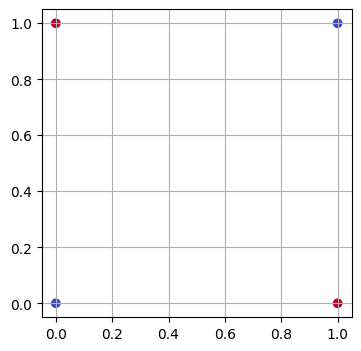

In [2]:
import matplotlib.pyplot as plt
import numpy as np

data_xs = np.array([[0,0],[0,1],[1,0],[1,1]])
data_ys = np.array([[0,1,1,0]])

fig,ax = plt.subplots(1,1,figsize=(4.,4.))
ax.scatter(data_xs[:,0],data_xs[:,1],c = data_ys.ravel(),cmap='coolwarm')
ax.grid(True)
plt.show()

Building a multilayer perceptron from scratch to solve the XOR classification problem. The final heatmap shows that the output correctly classifies the points.

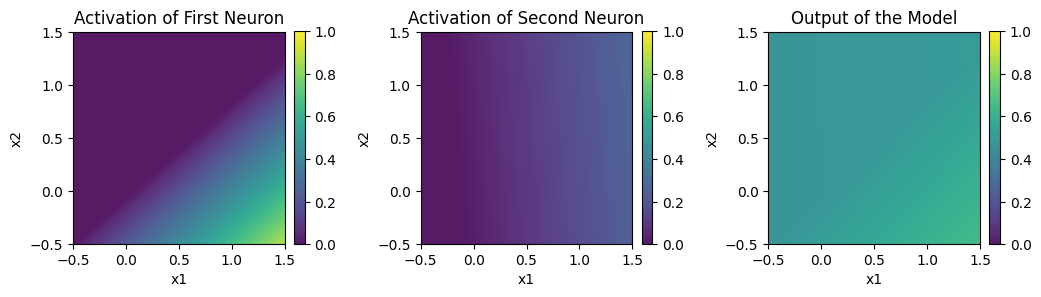

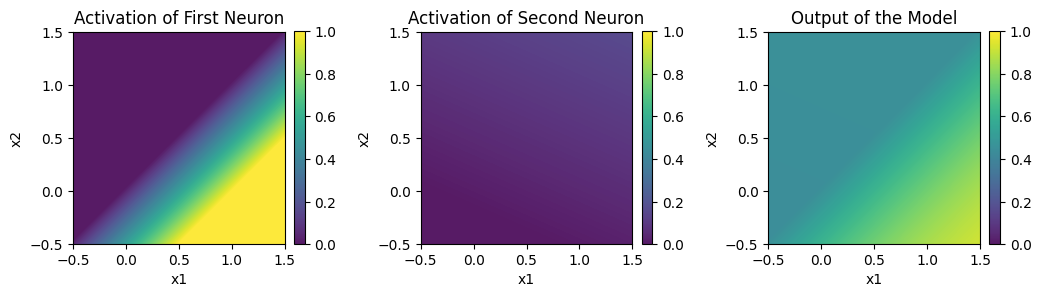

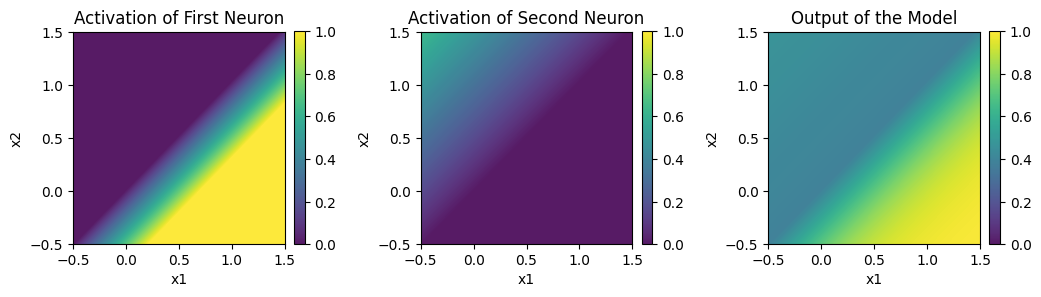

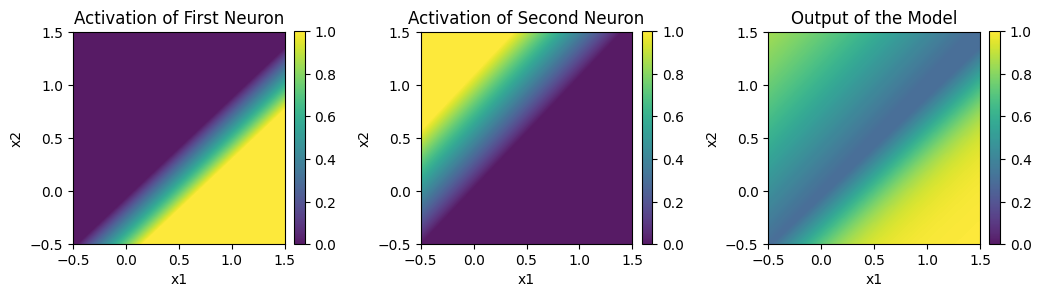

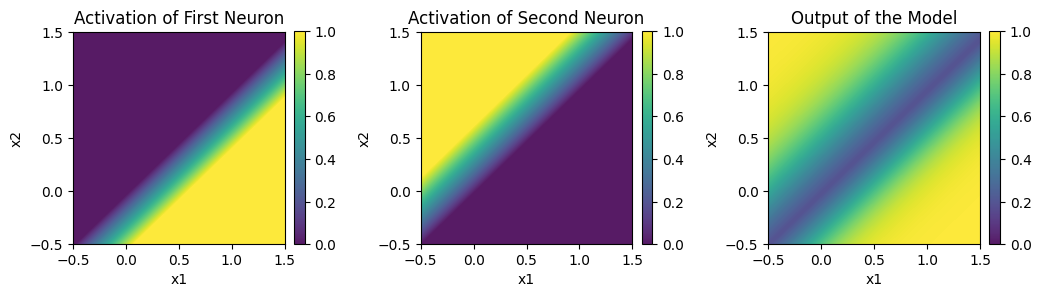

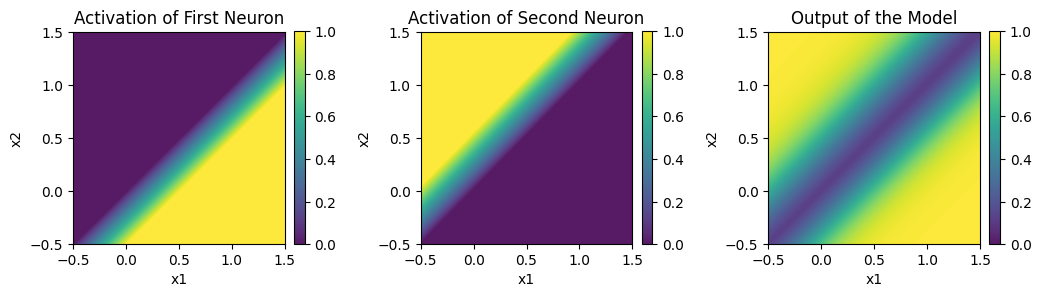

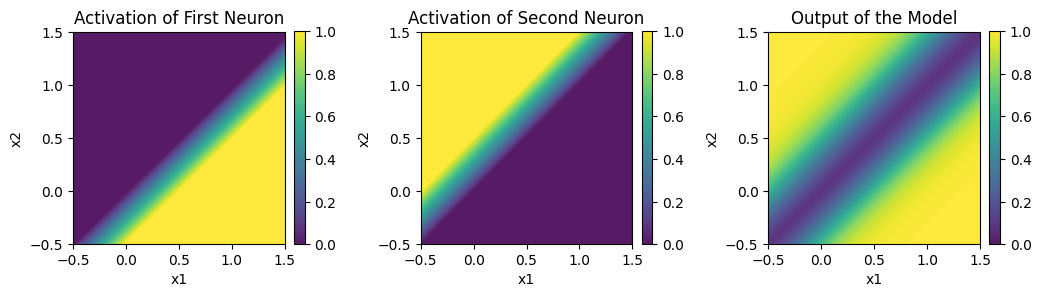

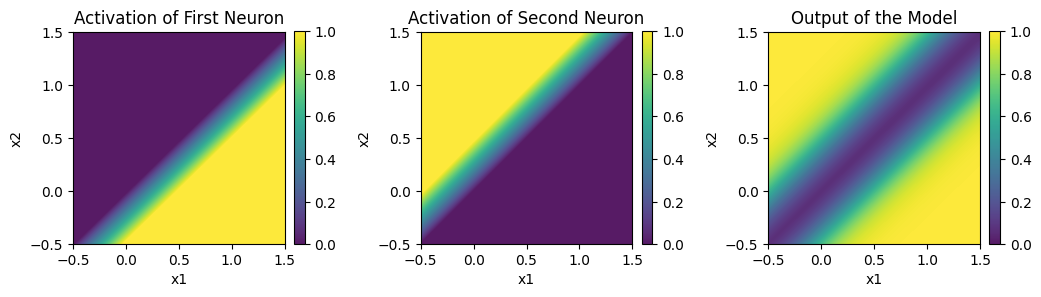

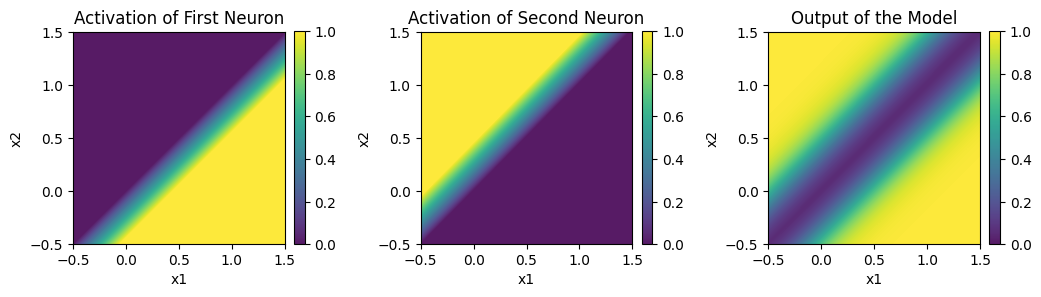

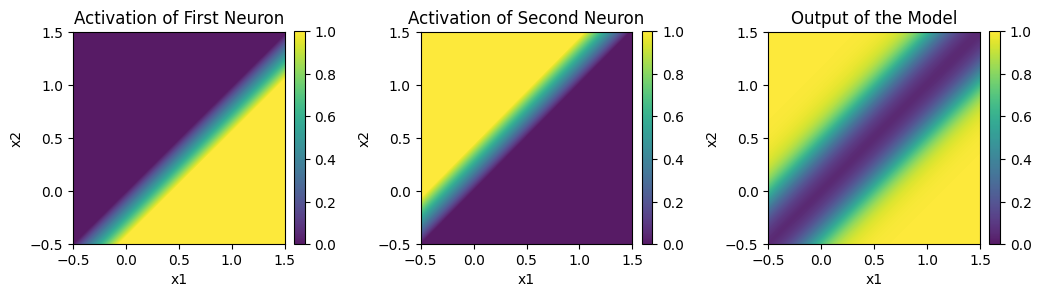

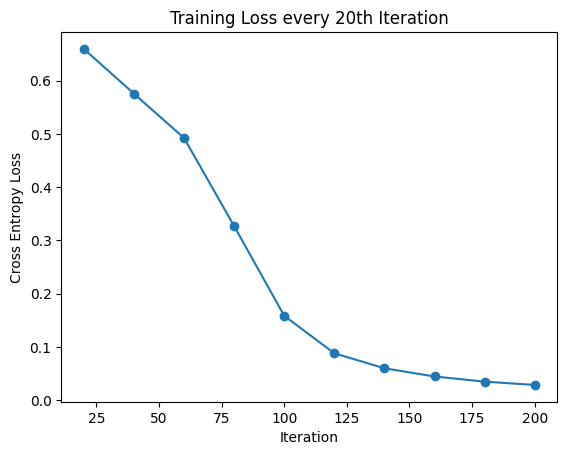

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def backprop(X, y, W_1, W_2, b_1, b_2):

  # Feed forward step of back propagation
  # --begin--
  # Multiplying weights and adding bias to get to first hidden layer
  # a_1 is 4x2 array
  a_1 = X.dot(W_1) + b_1

  # Apply ReLU activation to get features of first hidden layer
  # h is 4x2 array
  h = np.maximum(a_1, np.zeros(shape = a_1.shape))

  # Multiplying weights and adding bias to get to the output layer
  # a_2 is 4x1 array
  a_2 = h.dot(W_2) + b_2

  # Apply sigmoid activation function for the output layer (final output)
  # f is 4x1 array
  f = 1/(1 + np.exp(-a_2))
  # --end--

  # Back propagate step of back propagation
  # --begin--
  # derivative of the cross entropy loss
  # array of shape (4,)
  partial_L = (((-1/f).flatten()) * y) + (((1/(1 - f)).flatten()) * (1 - y))

  # derivative of sigmoid(x) which is sigmoid(x) * (1 - sigmoid(x))
  # array of shape (4,)
  partial_f = f.flatten() * (1 - f.flatten())

  # partial derivative wrt weights after hidden layer
  # array of shape (2,)
  partial_W2 = (1/X.shape[0]) * np.sum((partial_L * partial_f) * h.T, axis = 1)

  # partial derivative wrt bias after hidden layer
  # numpy float
  partial_b2 = (1/X.shape[0]) * np.sum(partial_L * partial_f)

  # derivative of the reLU activation at each of the two nodes
  # array of shape (4, 2)
  d_relu = np.where(a_1 <= 0, 0, 1)

  # partial derivative wrt the biases before hidden layer
  # array of shape (2,)
  partial_b1 = (1/X.shape[0]) * (partial_L * partial_f).\
    reshape(1, len(partial_f)).\
      dot((d_relu * W_2.flatten())).flatten()

  # partial derivative wrt the weights connecting to first node of hidden layer
  partial_W11 = (X[:,0] * (d_relu * W_2.flatten()).T).\
    dot((partial_L * partial_f).\
        reshape(len(X),1)).T

  # partial derivative wrt the weights connecting to second node of hidden layer
  partial_W12 = (X[:,1] * (d_relu * W_2.flatten()).T).\
    dot((partial_L * partial_f).\
        reshape(len(X),1)).T

  # partial derivative wrt the weights before hidden layer
  # array of shape (2,2)
  partial_W1 = (1/X.shape[0]) * np.vstack((partial_W11, partial_W12))
  # --end--

  # return the derivative wrt each parameter
  return partial_W1, partial_b1, partial_W2.reshape(2,1), partial_b2

# Training the MLP
np.random.seed(3)

# initialize the weights and biases
initial_W1 = np.random.uniform(-0.5, 0.5, 4).reshape(2,2)
initial_W2 = np.random.uniform(-0.5, 0.5, 2).reshape(2, 1)
initial_b1 = np.zeros(shape = (2,))
initial_b2 = np.zeros(1)[0]

old_W1 = initial_W1
old_W2 = initial_W2
old_b1 = initial_b1
old_b2 = initial_b2

# Set iteration count and learning rate lr
iter = 0
lr = 0.58

# Store training loss
train_loss = []

# Train for 200 iterations
for i in range(200):
  update = backprop(data_xs, data_ys.flatten(), old_W1, old_W2, old_b1, old_b2)

  W1 = old_W1 - (lr * update[0])
  W2 = old_W2 - (lr * update[2])
  b1 = old_b1 - (lr * update[1])
  b2 = old_b2 - (lr * update[3])

  iter = iter + 1

  # Whenever we reach 20 iterations
  if iter % 20 == 0:
    # calculate training loss
    a_1 = data_xs.dot(W1) + b1
    h = np.maximum(a_1, np.zeros(shape = a_1.shape))
    a_2 = h.dot(W2) + b2
    f = 1/(1 + np.exp(-a_2))
    L = (-1/len(data_xs)) * \
      np.sum((np.log(f).flatten() * data_ys.flatten()) +\
              ((1 - data_ys.flatten()) * np.log(1 - f).flatten()))
    train_loss.append(L)

    # Examine learned features and output of the model
    x1 = np.linspace(-0.5, 1.5, num = 500)
    x2 = np.linspace(-0.5, 1.5, num = 500)
    grid = np.meshgrid(x1,x2)
    grid_dat = np.hstack((grid[0].flatten(order = "F").\
                          reshape(250000, 1), grid[1].\
                            flatten(order = "F").reshape(250000, 1)))
    a_1 = grid_dat.dot(W1) + b1
    h = np.maximum(a_1, np.zeros(shape = a_1.shape))
    a_2 = h.dot(W2) + b2

    # output of model
    f = 1/(1 + np.exp(-a_2))
    f = np.reshape(f, (500,500), order = "F")
    f = np.flip(f, axis = 0)

    # output of the first neuron in hidden layer
    h1 = h[:,0].reshape((500,500), order = "F")
    h1 = np.flip(h1, axis = 0)

    # output of the second neuron in hidden layer
    h2 = h[:,1].reshape((500,500), order = "F")
    h2 = np.flip(h2, axis = 0)

    # Visualize output of model and hidden layer activations as heatmap
    fig, ax = plt.subplots(1, 3, figsize = (10,10))
    fig.tight_layout()

    # plot the heatmap visualizing the activation of first neuron in hidden layer
    plot_1 = ax[0].imshow(h1, norm = "linear",\
                          extent = [-0.5-(1/499),1.5, -0.5-(1/499), 1.5],\
                              alpha = 0.9, vmin = 0, vmax = 1)
    ax[0].set_title('Activation of First Neuron')
    ax[0].set_xlabel("x1")
    ax[0].set_ylabel("x2")
    plt.colorbar(plot_1, fraction=0.046, pad=0.04)

    # plot the heatmap visualizing the activation of second neuron in hidden layer
    plot_2 = ax[1].imshow(h2, norm = "linear", \
                          extent = [-0.5-(1/499), 1.5, -0.5-(1/499), 1.5],\
                              alpha = 0.9, vmin = 0, vmax = 1)
    ax[1].set_title('Activation of Second Neuron')
    ax[1].set_xlabel("x1")
    ax[1].set_ylabel("x2")
    plt.colorbar(plot_2, fraction=0.046, pad=0.04)

    # plot the heatmap visualizing the output of the model which is between 0 and 1
    plot_3 = ax[2].imshow(f, norm = "linear", \
                          extent = [-0.5-(1/499), 1.5, -0.5-(1/499), 1.5],\
                            alpha = 0.9, vmin = 0, vmax = 1)
    ax[2].set_title('Output of the Model')
    ax[2].set_xlabel("x1")
    ax[2].set_ylabel("x2")
    plt.colorbar(plot_3, fraction=0.046, pad=0.04)
    plt.subplots_adjust(wspace = 0.5)
    plt.show()

  old_W1 = W1
  old_W2 = W2
  old_b1 = b1
  old_b2 = b2

# Plot the training loss every 20th iteration
plt.scatter(np.array([20,40,60,80,100,120,140,160,180,200]), train_loss)
plt.plot(np.array([20,40,60,80,100,120,140,160,180,200]), train_loss)
plt.title("Training Loss every 20th Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cross Entropy Loss")
plt.show()